# Correlation and Relationships

Aktuell (im letzten NOtebook) stehen die Werte untereinander (eine Zeile pro Measure). Um zu testen, ob "Sicherheit" mit "Lebenszufriedenheit" korreliert, müssen diese als Spalten nebeneinander stehen. Wir müssen den Datensatz also umformen ("pivoten").

-> Bevor wir eine Zahl berechnen, müssen wir die Daten sehen. Ist der Zusammenhang linear? Gibt es "Wolken"?

## 1. Setup & Daten Laden

In [118]:
# !pip install pingouin
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
import pingouin as pg

In [119]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)

In [120]:
current_dir = Path.cwd()
data_path = current_dir.parent / 'data' / 'oecd_snapshot_latest.csv'

try:
    df = pd.read_csv(data_path)
    print("Daten erfolgreich geladen.")

    df = df.loc[:, ~df.columns.duplicated()]
        
except FileNotFoundError:
    print(f"FEHLER: Datei nicht gefunden unter {data_path}")

Daten erfolgreich geladen.


## 2. Daten Transformation

In [121]:
target_sex = 'Total' if 'Total' in df['sex'].unique() else '_T'
target_age = 'Total' if 'Total' in df['age'].unique() else '_T'

In [122]:
mask = (df['sex'] == target_sex) & (df['age'] == target_age)
df_filtered = df[mask].copy()

In [123]:
df_pivot = df_filtered.pivot_table(
    index='reference_area', 
    columns='measure', 
    values='value',
    aggfunc='mean' 
)

print(f"\nDatensatz transformiert. Anzahl Länder: {len(df_pivot)}")


Datensatz transformiert. Anzahl Länder: 47


### 3. VARIABLEN SELEKTION

In [124]:
# Zielvariable aus Notebook 2
target_var = "Feeling safe at night"

# Verfügbare Indikatoren prüfen
print(df_pivot.columns.tolist())

['Access to green space', 'Adult literacy skills', 'Adult numeracy skills', 'Adults with low literacy skills', 'Adults with low numeracy skills', 'Average annual gross earnings', 'Deaths from suicide, alcohol, drugs', 'Difficulty making ends meet', 'Employment rate', 'Equivalised liquid financial assets below three months of the annual national relative income poverty line', 'Exposed to air pollution', 'Exposure to extreme temperature', 'Feeling lonely', 'Feeling safe at night', 'Feelings of physical pain', 'Full-time employees earning less than two-thirds of gross median earnings', 'Gender gap in working hours', 'Gender wage gap', 'Having a say in government', 'Homicides', 'Household disposable income below the relative income poverty line', 'Households and NPISHs net adjusted disposable income per capita', 'Households living in overcrowded conditions', 'Households with internet access at home', 'Housing affordability', 'Housing cost overburden', 'Inability to keep home adequately war

In [125]:
potential_drivers = [
    "Social support",    
    "Homicides",         
    "Life satisfaction", 
    "Median net wealth",
    "Difficulty making ends meet"
]

In [126]:
# intersection, um Tippfehler abzufangen
cols_to_use = [target_var] + potential_drivers
# nur die Spalten nehmen, die auch wirklich da sind
valid_cols = df_pivot.columns.intersection(cols_to_use)
df_corr = df_pivot[valid_cols].copy()

# alle Daten -> Zahlenformat, alles was kein Text ist -> NaN
for col in df_corr.columns:
    df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')

# Wir löschen Länder, die in diesen Spalten NaNs haben (Listwise Deletion) -> Korrelation braucht vollständige Paare
df_corr = df_corr.dropna()

print(f"\nAnalyse-Tabelle erstellt mit {df_corr.shape[0]} Ländern.")
df_corr.head()


Analyse-Tabelle erstellt mit 26 Ländern.


measure,Difficulty making ends meet,Feeling safe at night,Homicides,Life satisfaction,Median net wealth,Social support
reference_area,,,,,,
Austria,13.1,82.546060,0.4,7.575,189148.0,89.024267
Belgium,17.2,68.829203,0.7,7.550,343656.0,91.298786
Canada,20.4,73.163202,0.8,7.400,336829.0,90.730572
Croatia,19.8,77.833333,0.7,7.125,151212.0,90.838590
Czechia,14.2,76.741255,0.5,7.425,193239.0,93.843487


## 4. Visuelle Prüfung

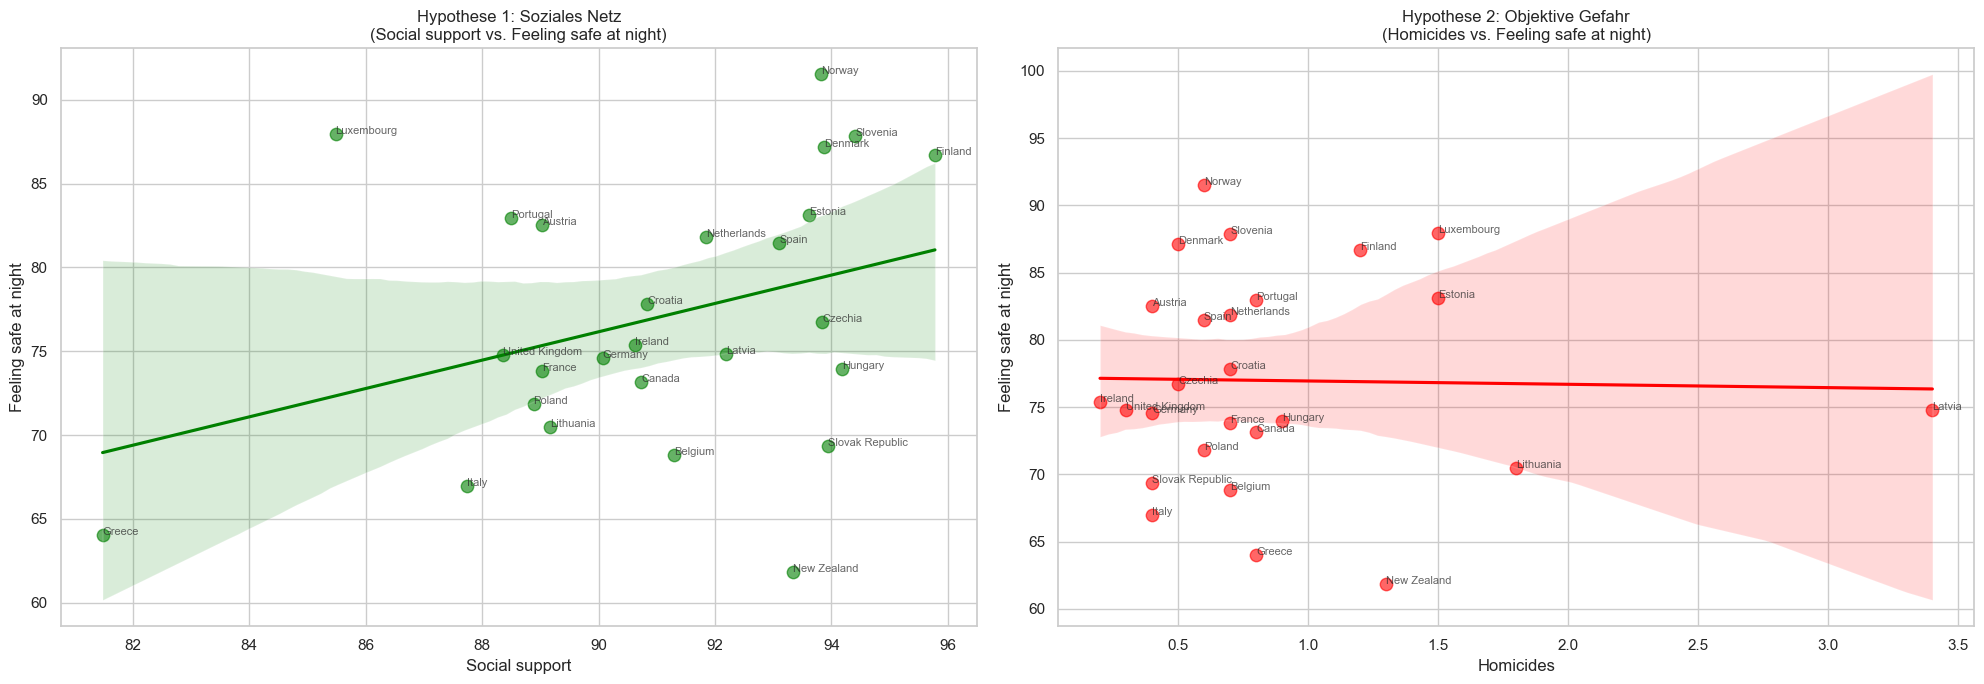

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot 1: Social Support
sns.regplot(data=df_corr, x="Social support", y=target_var, ax=ax[0], 
            color="green", scatter_kws={'s': 80, 'alpha': 0.6})
ax[0].set_title(f"Hypothese 1: Soziales Netz\n(Social support vs. {target_var})")

# Plot 2: Homicides
sns.regplot(data=df_corr, x="Homicides", y=target_var, ax=ax[1], 
            color="red", scatter_kws={'s': 80, 'alpha': 0.6})
ax[1].set_title(f"Hypothese 2: Objektive Gefahr\n(Homicides vs. {target_var})")

for i in range(df_corr.shape[0]):
    ax[0].text(df_corr["Social support"].iloc[i], df_corr[target_var].iloc[i], 
               df_corr.index[i], fontsize=8, alpha=0.7)
    ax[1].text(df_corr["Homicides"].iloc[i], df_corr[target_var].iloc[i], 
               df_corr.index[i], fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

## 5. Korrelation

Wir berechnen Spearman, da wir in Notebook 2 Ausreißer gesehen haben (robuster Ansatz)

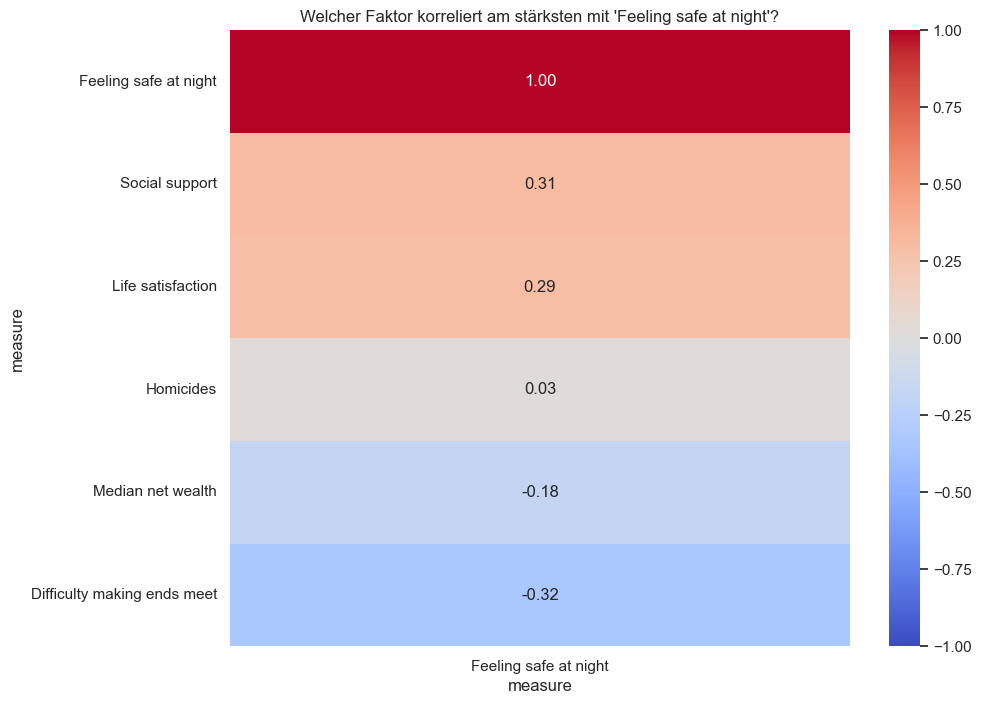

In [128]:
corr_matrix = df_corr.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[[target_var]].sort_values(by=target_var, ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title(f"Welcher Faktor korreliert am stärksten mit '{target_var}'?")
plt.show()

In [129]:
corr_spearman, p_spearman = stats.spearmanr(df_corr[v1], df_corr[v2])
corr_kendall, p_kendall = stats.kendalltau(df_corr[v1], df_corr[v2])

print(f"--- Vergleich der Rangkorrelationen für '{v1}' vs. '{v2}' ---")
print(f"Spearman rho: {corr_spearman:.4f} (p={p_spearman:.4f})")
print(f"Kendall tau:  {corr_kendall:.4f} (p={p_kendall:.4f})")

--- Vergleich der Rangkorrelationen für 'Feeling safe at night' vs. 'Life satisfaction' ---
Spearman rho: 0.2896 (p=0.1512)
Kendall tau:  0.1866 (p=0.1852)


### Warum Kendall’s Tau? 

Obwohl Spearman der Standard für nicht-parametrische Daten ist, berechnen wir ergänzend Kendall’s Tau (τ).

Stichprobengröße: Unser Datensatz (nach der Aggregation auf Länderebene) ist relativ klein (n<30). Kendall’s Tau liefert bei kleinen Stichproben oft robustere Schätzungen und p-Werte als Spearman.

Während Spearman die Korrelation von Rängen misst, basiert Kendall auf der Wahrscheinlichkeit von Konkordanz (Paare ordnen sich gleich) vs. Diskordanz. Das ist intuitiv oft sauberer, wenn es viele Ties gibt.

Wenn Spearman und Kendall in die gleiche Richtung zeigen und ähnliche Signifikanzniveaus haben, können wir von einem sehr stabilen Zusammenhang ausgehen, der nicht von der Wahl des Rang-Korrelationskoeffizienten abhängt.

## 6. Hypothesentest

In [130]:
def test_correlation(var_name):
    """Führt einen Spearman-Test gegen die Zielvariable durch und gibt das Ergebnis aus."""
    
    # 1. Hypothesen aufstellen
    print(f"\n--- Test: {target_var} vs. {var_name} ---")
    print("H0: Es gibt keinen monotonen Zusammenhang (rho = 0).")
    print("H1: Es gibt einen monotonen Zusammenhang (rho != 0).")
    
    # 2. Test durchführen
    corr, p_val = stats.spearmanr(df_corr[target_var], df_corr[var_name])
    
    # 3. Ergebnisse
    print(f"Spearman-Korrelation (rho): {corr:.4f}")
    print(f"p-Wert: {p_val:.6f}")
    
    # 4. Entscheidung
    alpha = 0.05
    if p_val < alpha:
        print("ENTCHEIDUNG: p < 0.05 -> H0 verwerfen. Der Zusammenhang ist signifikant.")
    else:
        print("ENTCHEIDUNG: p >= 0.05 -> H0 beibehalten. Kein signifikanter Zusammenhang nachweisbar.")

# Wir testen unsere beiden Haupt-Kandidaten
test_correlation("Social support")
test_correlation("Homicides")


--- Test: Feeling safe at night vs. Social support ---
H0: Es gibt keinen monotonen Zusammenhang (rho = 0).
H1: Es gibt einen monotonen Zusammenhang (rho != 0).
Spearman-Korrelation (rho): 0.3060
p-Wert: 0.128458
ENTCHEIDUNG: p >= 0.05 -> H0 beibehalten. Kein signifikanter Zusammenhang nachweisbar.

--- Test: Feeling safe at night vs. Homicides ---
H0: Es gibt keinen monotonen Zusammenhang (rho = 0).
H1: Es gibt einen monotonen Zusammenhang (rho != 0).
Spearman-Korrelation (rho): 0.0293
p-Wert: 0.887165
ENTCHEIDUNG: p >= 0.05 -> H0 beibehalten. Kein signifikanter Zusammenhang nachweisbar.


## 7. DRITTVARIABLEN-CHECK


Drittvariable kontrollieren: Median Wealth Split bei 186496.0


<Figure size 1000x600 with 0 Axes>

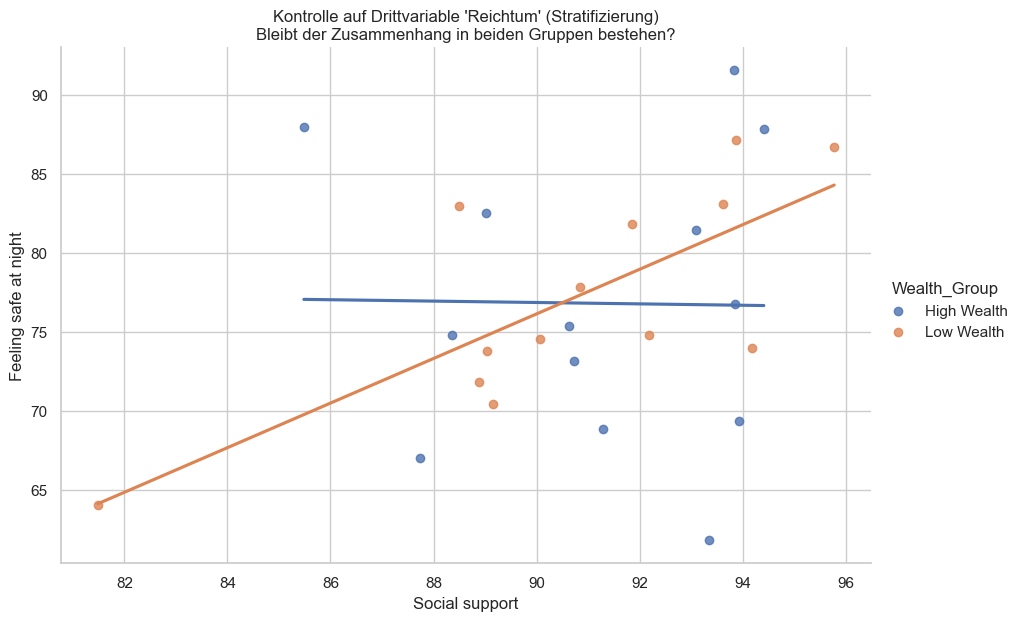

In [131]:
wealth_median = df_corr["Median net wealth"].median()
df_corr["Wealth_Group"] = np.where(df_corr["Median net wealth"] > wealth_median, "High Wealth", "Low Wealth")

print(f"\nDrittvariable kontrollieren: Median Wealth Split bei {wealth_median}")

plt.figure(figsize=(10, 6))
sns.lmplot(data=df_corr, x="Social support", y=target_var, hue="Wealth_Group", 
           height=6, aspect=1.5, ci=None)

plt.title("Kontrolle auf Drittvariable 'Reichtum' (Stratifizierung)\nBleibt der Zusammenhang in beiden Gruppen bestehen?")
plt.show()

### Korrelation $\neq$ Kausalität

Wir haben statistisch signifikante Zusammenhänge gefunden. 

1.  **Drittvariablen-Problem (Confounding):**
    * Es ist möglich, dass sowohl das Sicherheitsgefühl als auch z.B. die Lebenszufriedenheit durch eine dritte, nicht gemessene Variable beeinflusst werden (z.B. *Politische Stabilität* oder *Qualität des Gesundheitssystems*).
    * Beispiel: Reiche Länder haben oft beides – hohe Sicherheit und hohe Zufriedenheit. Der Zusammenhang könnte also rein ökonomisch getrieben sein.

2.  **Simpson-Paradox:**
    * Da wir Daten auf Länderebene aggregiert haben ("Ecological Fallacy"), gilt der gefundene Zusammenhang nicht zwingend für Individuen. Es könnte sein, dass in *einem* Land reichere Menschen *nicht* sicherer sind, obwohl der Trend im Ländervergleich so aussieht.

**Fazit:** Die Korrelationen sind starke Hinweise auf strukturelle Zusammenhänge, aber kein Beweis für einen direkten ursächlichen Mechanismus.

## 8. PARTIELLE KORRELATION

In [132]:
try:
    pcorr_df = df_corr.pcorr()

    stats_pcorr = pg.partial_corr(data=df_corr, x='Social support', y=target_var, 
                                 covar='Median net wealth', method='spearman')
    
    print("\n--- Partielle Korrelation (Kontrolle auf Reichtum) ---")
    print(stats_pcorr)
    
except ImportError:
    print("Pingouin nicht installiert. Führe '!pip install pingouin' aus für detaillierte Partial-Corr.")
    corrs = df_corr.groupby("Wealth_Group")[["Social support", target_var]].corr(method="spearman").iloc[0::2, -1]
    print("\n--- Korrelation in den Subgruppen (Stratifizierung) ---")
    print(corrs)


--- Partielle Korrelation (Kontrolle auf Reichtum) ---
           n         r         CI95%     p-val
spearman  26  0.271128  [-0.14, 0.6]  0.189873
